## Importing Libraries

In [1]:
! pip install gdown
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
sns.set_theme()
import pandas as pd
pd.set_option('display.max_colwidth', -1)

  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=d91987807bea7937c6ad4fb18ba9046d4e0449925d70b95ad97d56220656421d
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## Getting our dataset

### METHOD1: Making the dataset from txt file

Downloading dataset from google drive and unzipping it

In [2]:
# !gdown --id 1D3yt99D0GcCRCbdKbUQGxbqjkeh91hTg
# !unrar x /content/hamshahri.rar
# !unzip /content/hamshahriold/Corpus/Hamshahri-Corpus.zip
# !unzip /content/hamshahriold/Corpus/PersianStopWords.zip

In [3]:
# stop_words = []
# with open("PersianStopWords.txt", "r", encoding="utf-8") as stopwords_retriever:
#   for line in stopwords_retriever:
#     word = line.strip()
#     stop_words.append(word)

# stopwords_retriever.close()

Writing data rows to a list

In [4]:
# !pip install hazm
# from __future__ import unicode_literals
# from hazm import *

In [5]:
# row = ["","","",""]
# rows = []
# is_first = True
# with open("Hamshahri-Corpus.txt", "r", encoding="utf-8") as corpus_reader:
#   for line in corpus_reader:
#     stripped_line = line.strip()
#     if stripped_line == "":
#         continue
            
#     else: 
#         if (stripped_line.startswith(".DID")):
#             if is_first:
#                 is_first = False
#             else:
#                 # Removing stopwords from rows in each iteration
#                 row[3] = [word for word in word_tokenize(row[3]) if word not in stop_words]
#                 row[3] = [x for x in row[3] if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
#                 row[3] = ' '.join(row[3])
#                 rows.append(row)
#                 row = ["","","",""]
#             row[0] = stripped_line.split(".DID\t", 1)[1]
#         elif (stripped_line.startswith(".Date")):
#             row[1] = stripped_line.split(".Date\t", 1)[1]
#         elif (stripped_line.startswith(".Cat")):
#             row[2] = stripped_line.split(".Cat\t", 1)[1]
#         else:
#             row[3] += stripped_line + " "
    
# corpus_reader.close()

#### Making a CSV file from rows list

In [6]:
# import csv

# header = ['DID', 'Date', 'Cat', 'News']

# with open('corpus.csv', 'w', encoding='utf-8', newline='') as corpus_writer:
#     writer = csv.writer(corpus_writer)

#     # write the header
#     writer.writerow(header)

#     # write multiple rows
#     writer.writerows(rows)

# corpus_writer.close()

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r "/content/corpus.csv" "/content/drive/MyDrive/corpus.csv"

### METHOD2: Using premade CSV file

In [8]:
!gdown --id 1w4-vTNQ4sXLBcXqG7TCjhNEtQg3cveiH


/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1w4-vTNQ4sXLBcXqG7TCjhNEtQg3cveiH
To: /kaggle/working/corpus.csv
100%|█████████████████████████████████████████| 426M/426M [00:01<00:00, 369MB/s]


## Reading dataset with pandas library

In [9]:
df = pd.read_csv("corpus.csv")
df.set_index('DID', inplace=True)
df.drop_duplicates(keep='last', inplace=True) 

getting number of Categories

In [10]:
print("We have a total of {} categories".format(df['Cat'].nunique()))
df['Cat'].value_counts()
number_of_unique_cat = df['Cat'].nunique()

We have a total of 105 categories


## Plotting the categories

In [11]:
categories = dict(df['Cat'].value_counts())
categories_with_small_counts = dict(df['Cat'].value_counts().tail(92))
for i in list(categories_with_small_counts):
  if (i in categories_with_small_counts.keys()):
     categories.pop(i, None)

In [12]:
categories.update({"Others":df['Cat'].value_counts().tail(92).sum()})

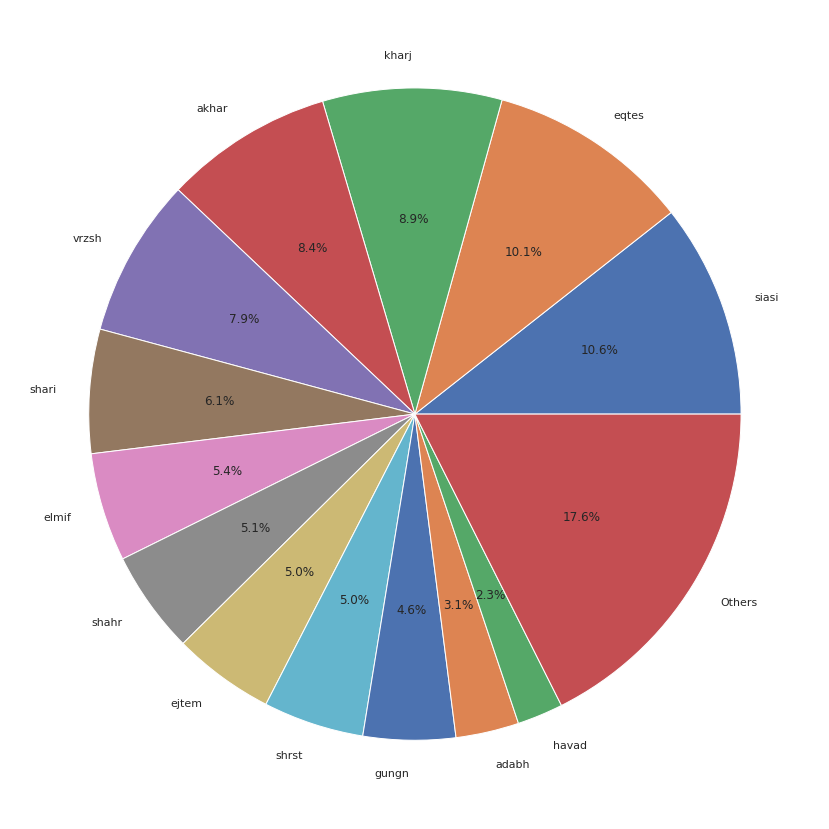

In [13]:
fig = plt.figure(figsize=(15,15))
plt.pie(categories.values(), 
        labels=categories.keys(),
        autopct='%1.1f%%');

## Making our train, validation and test data

In [14]:
X,Y = df['News'],df['Cat']
X_train, X_val, y_train, y_val = train_test_split(X,pd.get_dummies(Y), test_size=0.2, random_state = 40)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state = 40)
X_train = X_train.astype(str)
X_val = X_val.astype(str)
X_test = X_test.astype(str)

In [15]:
vocab_size =20000
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

## Tokenizing and Padding

In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_train = np.asarray(y_train)
# y_train = pd.get_dummies(y_train)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
# y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


# y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1)   #this would be our ground truth label while testing

print(train_set.shape)
print(train_label.shape)


print(val_set.shape)
print(val_label.shape)


num_tokens = len(tokenizer.word_index.items()) + 2
embedding_dim = 50

(132175, 300)
(132175, 105)
(16522, 300)
(16522, 105)


## Training the Model

In [17]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

tf.keras.backend.clear_session()
model = keras.models.Sequential([
                                 
        Embedding(num_tokens, embedding_dim, input_length = max_length),
        keras.layers.LSTM(256, dropout = 0.6),
        keras.layers.Dense(number_of_unique_cat, activation="softmax")
            
        ])


model.summary()

2022-07-13 15:19:35.188303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:19:35.310284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:19:35.311077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:19:35.312520: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 50)           19693300  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
dense (Dense)                (None, 105)               26985     
Total params: 20,034,653
Trainable params: 20,034,653
Non-trainable params: 0
_________________________________________________________________


In [18]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit( train_set,train_label,
                     batch_size = 32,
                     validation_data = (val_set , val_label),
                     validation_steps = len(val_set)//32, epochs=20,
                     callbacks=  early_stop )

2022-07-13 15:19:38.795667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-13 15:19:41.281741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4131/4131 [==============================] - 125s 29ms/step - loss: 3.0150 - accuracy: 0.1404 - val_loss: 2.6021 - val_accuracy: 0.2558
Epoch 2/20
4131/4131 [==============================] - 120s 29ms/step - loss: 2.3900 - accuracy: 0.3349 - val_loss: 1.9220 - val_accuracy: 0.4460
Epoch 3/20
4131/4131 [==============================] - 120s 29ms/step - loss: 1.5301 - accuracy: 0.5757 - val_loss: 1.1918 - val_accuracy: 0.6639
Epoch 4/20
4131/4131 [==============================] - 120s 29ms/step - loss: 1.0778 - accuracy: 0.7030 - val_loss: 0.9615 - val_accuracy: 0.7343
Epoch 5/20
4131/4131 [==============================] - 120s 29ms/step - loss: 0.9053 - accuracy: 0.7472 - val_loss: 0.8706 - val_accuracy: 0.7544
Epoch 6/20
4131/4131 [==============================] - 120s 29ms/step - loss: 0.8064 - accuracy: 0.7707 - val_loss: 0.8207 - val_accuracy: 0.7654
Epoch 7/20
4131/4131 [==============================] - 120s 29ms/step - loss: 0.7334 - accuracy: 0.7889 - val_loss: 0.8048 - val

### Ploting the training process

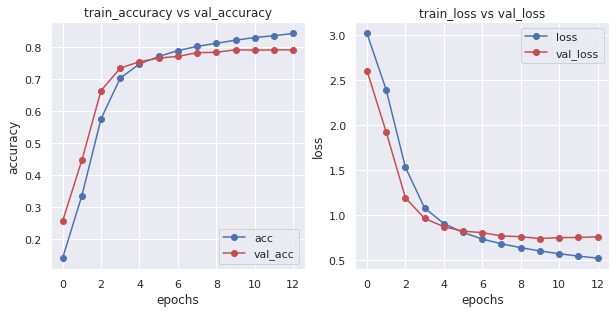

In [19]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

## Testing the Model

In [20]:
classes = df['Cat'].value_counts().index

def prediction(inference_data):
    X = tokenizer.texts_to_sequences(inference_data)
    X = pad_sequences(X,maxlen= max_length,padding=padding_type, truncating=trunc_type)
    pred = model.predict(X)
    pred_value = tf.argmax(pred,axis =1).numpy()                
    return pred_value

In [21]:
y_pred = prediction(X_test)
print(classification_report(np.asarray(y_test),np.asarray( y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.43      0.45      0.44        67
           7       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.50      0.33      0.40         3
          23       0.36      0.45      0.40        44
          24       0.71      0.66      0.68       514
          25       0.00      0.00      0.00         5
          26       0.43      0.44      0.44       142
          27       0.76      0.82      0.78      1342
          28       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Save Model

In [22]:
!pip install tables
import tables
model.save("final_classifier.h5")

tables.file._open_files.close_all()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 13.1 MB/s eta 0:00:00


### Load Model

In [23]:
# !gdown --id 1DkFDtvvug3GG3uPWUv_C3P9Y0SZu5HG8

# from keras.models import load_model
# model = load_model("final_classifier.h5.h5")